In [1]:
! pip install \
    pandas \
    matplotlib \
    statsmodels

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np

LOGS_PATH = 'tmp/logs_2025-09-04_16-09-13.csv'

In [3]:
df_logs = pd.read_csv(LOGS_PATH, parse_dates=['timestamp'])
print(df_logs.shape)
df_logs.sample(1).T.to_dict()

(465750, 9)


{416227: {'timestamp': '2025-09-04 15:29:32.335000+00:00',
  'tasks': '5-5-1',
  'batch_id': 11,
  'processed_%': 44.0,
  'seconds': 2.251,
  'dag_id': 8,
  'task_type': 'extractors',
  'run_id': 'f67281cc-99c0-46df-9143-fc5d0c4a5b4f',
  'task_id': 2}}

In [4]:
cols = ['extractors', 'transformers', 'loaders']
df_time_span = (
    df_logs
    .groupby(['run_id', 'task_type', 'tasks'])['timestamp']
    .agg(start_time='min', end_time='max')
    .reset_index()
)
df_time_span['start_time'] = pd.to_datetime(
    df_time_span['start_time'], errors='coerce')
df_time_span['end_time'] = pd.to_datetime(
    df_time_span['end_time'], errors='coerce')
df_time_span['duration'] = (
    df_time_span['end_time'] - df_time_span['start_time']
).dt.total_seconds()
df_time_span

,run_id,task_type,tasks,start_time,end_time,duration
0,004c9b2b-a7e3-4cc8-9195-516daf52a991,extractors,2-2-5,2025-09-04 13:13:07.935000+00:00,2025-09-04 13:15:22.147000+00:00,134.212
1,004c9b2b-a7e3-4cc8-9195-516daf52a991,loaders,2-2-5,2025-09-04 13:12:49.026000+00:00,2025-09-04 13:14:00.205000+00:00,71.179
2,004c9b2b-a7e3-4cc8-9195-516daf52a991,transformers,2-2-5,2025-09-04 13:12:51.729000+00:00,2025-09-04 13:16:54.384000+00:00,242.655
3,006d70da-76ac-4e72-9d7c-4245b29c99b9,extractors,3-4-3,2025-09-04 15:04:14.369000+00:00,2025-09-04 15:05:39.407000+00:00,85.038
4,006d70da-76ac-4e72-9d7c-4245b29c99b9,loaders,3-4-3,2025-09-04 15:04:14.366000+00:00,2025-09-04 15:05:42.638000+00:00,88.272
...,...,...,...,...,...,...
3745,ffb1cafc-0ba6-4b2f-a812-91ca21ba21da,loaders,1-2-1,2025-09-04 14:21:37.345000+00:00,2025-09-04 14:26:00.162000+00:00,262.817
3746,ffb1cafc-0ba6-4b2f-a812-91ca21ba21da,transformers,1-2-1,2025-09-04 14:21:39.134000+00:00,2025-09-04 14:25:29.719000+00:00,230.585
3747,ffd88ab6-fe8c-423c-9645-3c50e52fc892,extractors,3-4-4,2025-09-04 13:44:56.116000+00:00,2025-09-04 13:46:37.329000+00:00,101.213
3748,ffd88ab6-fe8c-423c-9645-3c50e52fc892,loaders,3-4-4,2025-09-04 13:44:52.332000+00:00,2025-09-04 13:46:08.958000+00:00,76.626


In [5]:
df_grouped = (
    df_time_span.copy()[['run_id', 'task_type', 'tasks', 'duration']]
    .pivot(index=['run_id', 'tasks'], columns='task_type', values='duration')
    .fillna(0)
    .reset_index()
)
df_grouped['total_pipeline_time'] = df_grouped[cols].max(axis=1)
df_grouped

task_type,run_id,tasks,extractors,loaders,transformers,total_pipeline_time
0,004c9b2b-a7e3-4cc8-9195-516daf52a991,2-2-5,134.212,71.179,242.655,242.655
1,006d70da-76ac-4e72-9d7c-4245b29c99b9,3-4-3,85.038,88.272,115.678,115.678
2,00b63057-7a64-4d33-957b-c13ab0948286,1-3-4,264.096,64.227,152.292,264.096
3,00b8bb56-e57e-4a4c-9d21-b7fa5ab6fdbb,2-4-1,133.498,262.321,116.756,262.321
4,00d7f798-785d-42cf-8e81-dab72335849c,5-5-5,90.525,91.843,125.131,125.131
...,...,...,...,...,...,...
1245,fe90aadd-4893-42ef-a014-f9f3773b5a5a,5-5-4,69.864,66.284,92.487,92.487
1246,ff83e3e6-4d25-4d48-a7d8-7563c259db61,5-1-3,61.182,88.803,460.323,460.323
1247,ff94d0bc-1e5e-4cba-8f9e-dfda9e7b9f9c,5-4-1,52.745,257.945,113.133,257.945
1248,ffb1cafc-0ba6-4b2f-a812-91ca21ba21da,1-2-1,264.944,262.817,230.585,264.944


In [6]:
result = df_grouped.copy()
result['etl_variance'] = round(result[cols].var(axis=1), 3)
result['batches_rate'] = round(125 / result['total_pipeline_time'], 2)
result

task_type,run_id,tasks,extractors,loaders,transformers,total_pipeline_time,etl_variance,batches_rate
0,004c9b2b-a7e3-4cc8-9195-516daf52a991,2-2-5,134.212,71.179,242.655,242.655,7522.844,0.52
1,006d70da-76ac-4e72-9d7c-4245b29c99b9,3-4-3,85.038,88.272,115.678,115.678,283.393,1.08
2,00b63057-7a64-4d33-957b-c13ab0948286,1-3-4,264.096,64.227,152.292,264.096,10033.866,0.47
3,00b8bb56-e57e-4a4c-9d21-b7fa5ab6fdbb,2-4-1,133.498,262.321,116.756,262.321,6344.138,0.48
4,00d7f798-785d-42cf-8e81-dab72335849c,5-5-5,90.525,91.843,125.131,125.131,384.567,1.00
...,...,...,...,...,...,...,...,...
1245,fe90aadd-4893-42ef-a014-f9f3773b5a5a,5-5-4,69.864,66.284,92.487,92.487,201.869,1.35
1246,ff83e3e6-4d25-4d48-a7d8-7563c259db61,5-1-3,61.182,88.803,460.323,460.323,49683.928,0.27
1247,ff94d0bc-1e5e-4cba-8f9e-dfda9e7b9f9c,5-4-1,52.745,257.945,113.133,257.945,11120.711,0.48
1248,ffb1cafc-0ba6-4b2f-a812-91ca21ba21da,1-2-1,264.944,262.817,230.585,264.944,370.661,0.47


In [7]:
agg_result = (
    result
    .groupby('tasks')
    .agg(
        mean_time=('total_pipeline_time', 'mean'),
        std_time=('total_pipeline_time', 'std'),
        mean_extractors=('extractors', 'mean'),
        mean_transformers=('transformers', 'mean'),
        mean_loaders=('loaders', 'mean'),
        mean_rate=('batches_rate', 'mean')
    )
    .reset_index()
    .sort_values(by='mean_time', ascending=False)
    .round(2)
)
agg_result

,tasks,mean_time,std_time,mean_extractors,mean_transformers,mean_loaders,mean_rate
53,3-1-4,463.35,3.72,98.17,463.35,77.12,0.27
0,1-1-1,462.39,4.36,262.52,462.39,260.51,0.27
54,3-1-5,462.24,5.11,104.61,462.24,78.23,0.27
25,2-1-1,462.18,3.60,119.49,462.18,260.75,0.27
27,2-1-3,461.78,3.47,132.58,461.78,89.75,0.27
...,...,...,...,...,...,...,...
122,5-5-3,113.86,16.07,64.59,113.36,95.70,1.12
97,4-5-3,113.65,11.10,76.34,110.76,99.78,1.11
123,5-5-4,112.58,12.34,68.88,112.58,75.10,1.12
124,5-5-5,109.01,12.82,74.34,108.65,74.51,1.16


In [8]:
agg_result.sample(1).T.to_dict()

{46: {'tasks': '2-5-2',
  'mean_time': 150.44,
  'std_time': 23.84,
  'mean_extractors': 141.34,
  'mean_transformers': 113.23,
  'mean_loaders': 140.78,
  'mean_rate': 0.85}}

In [9]:
df_111 = agg_result.copy()[agg_result['tasks'] == '1-1-1']
cols = ['mean_extractors', 'mean_transformers', 'mean_loaders']
sequential_time = sum([df_111[c].values[0] for c in cols])
agg_result['sequential_time'] = sequential_time
print(sequential_time, 'seconds')
agg_result

985.42 seconds


,tasks,mean_time,std_time,mean_extractors,mean_transformers,mean_loaders,mean_rate,sequential_time
53,3-1-4,463.35,3.72,98.17,463.35,77.12,0.27,985.42
0,1-1-1,462.39,4.36,262.52,462.39,260.51,0.27,985.42
54,3-1-5,462.24,5.11,104.61,462.24,78.23,0.27,985.42
25,2-1-1,462.18,3.60,119.49,462.18,260.75,0.27,985.42
27,2-1-3,461.78,3.47,132.58,461.78,89.75,0.27,985.42
...,...,...,...,...,...,...,...,...
122,5-5-3,113.86,16.07,64.59,113.36,95.70,1.12,985.42
97,4-5-3,113.65,11.10,76.34,110.76,99.78,1.11,985.42
123,5-5-4,112.58,12.34,68.88,112.58,75.10,1.12,985.42
124,5-5-5,109.01,12.82,74.34,108.65,74.51,1.16,985.42


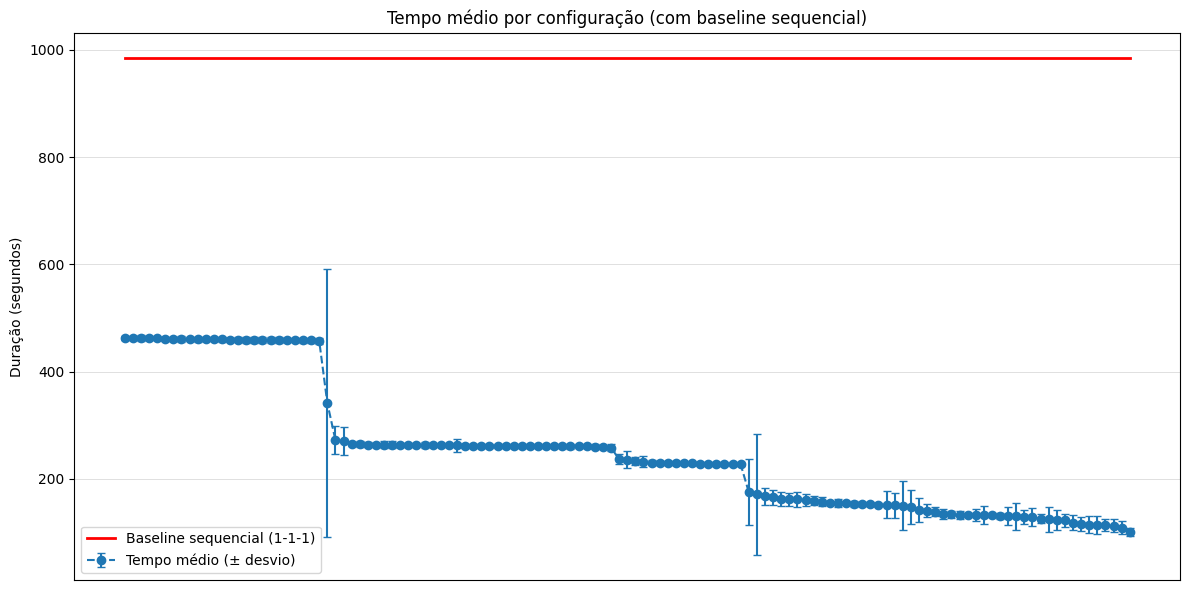

In [10]:
plt.figure(figsize=(12, 6))
plt.errorbar(
    np.arange(len(agg_result)),
    agg_result["mean_time"],
    yerr=agg_result["std_time"],
    fmt="o--",
    capsize=3,
    label="Tempo médio (± desvio)"
)

plt.plot(
    np.arange(len(agg_result)),
    agg_result["sequential_time"],
    linewidth=2,
    color="red",
    label="Baseline sequencial (1-1-1)"
)

plt.xticks([])
plt.ylabel("Duração (segundos)")
plt.title("Tempo médio por configuração (com baseline sequencial)")
plt.legend()
plt.tight_layout()
plt.grid(color="lightgray", linewidth=0.5, axis="y")
plt.show()

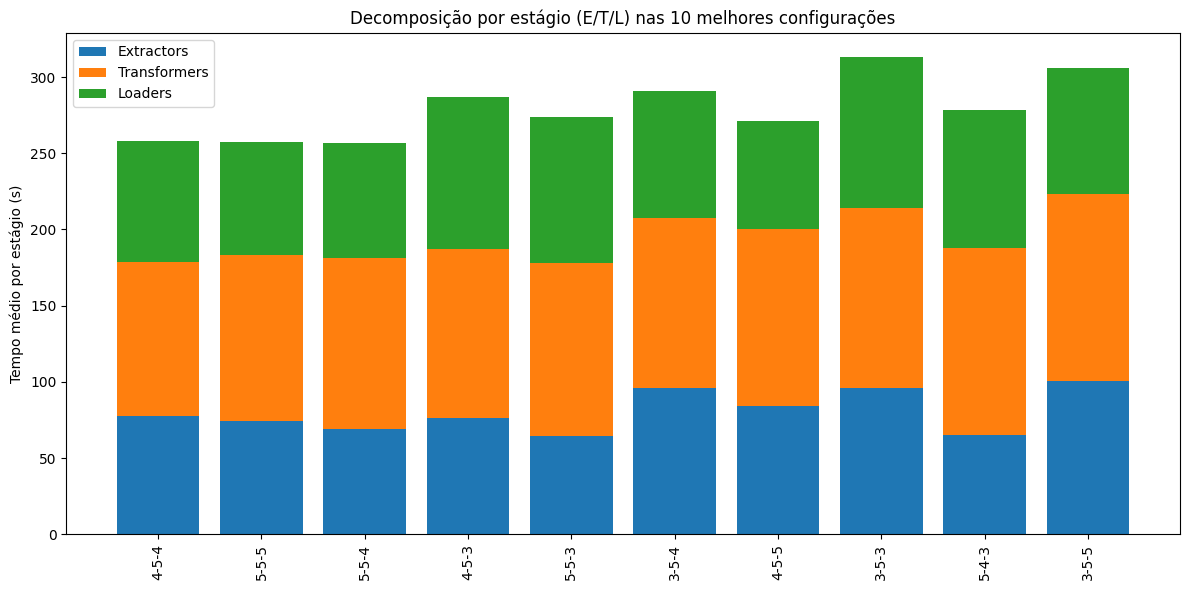

In [21]:
N = 10
best = agg_result.nsmallest(N, "mean_time").copy().reset_index(drop=True)

x = np.arange(len(best))
width = 0.8 

e = best["mean_extractors"].values
t = best["mean_transformers"].values
l = best["mean_loaders"].values

plt.figure(figsize=(12, 6))
plt.bar(x, e, width, label="Extractors")
plt.bar(x, t, width, bottom=e, label="Transformers")
plt.bar(x, l, width, bottom=e+t, label="Loaders")

plt.xticks(x, best["tasks"], rotation=90)
plt.ylabel("Tempo médio por estágio (s)")
plt.title(f"Decomposição por estágio (E/T/L) nas {N} melhores configurações")
plt.legend()
plt.tight_layout()
plt.show()


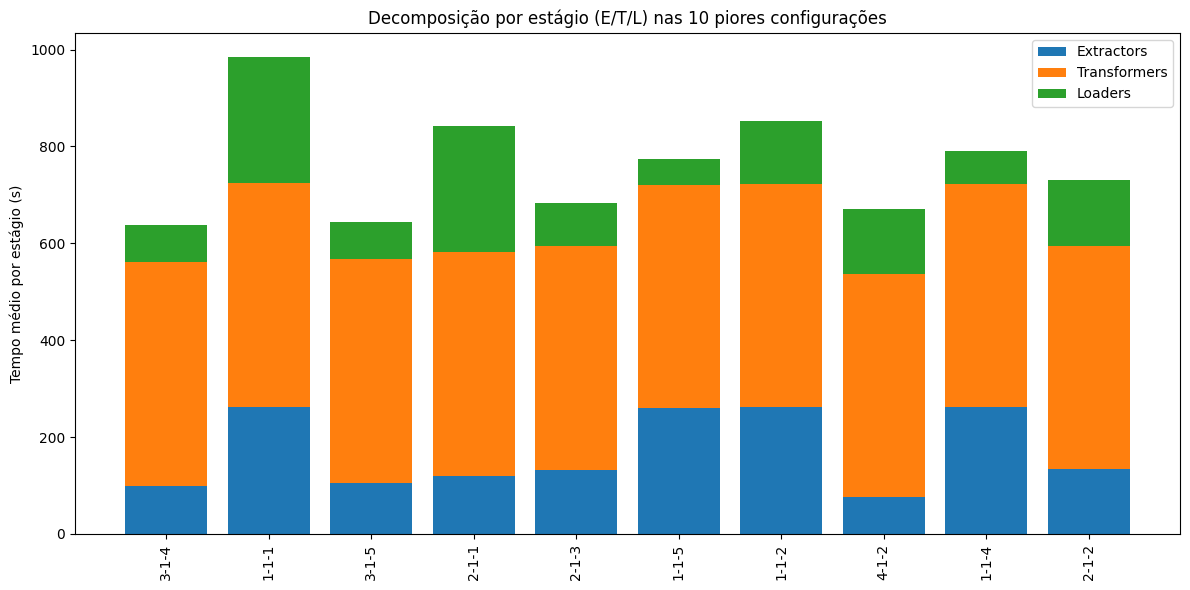

In [13]:
N = 10
worst = agg_result.nlargest(N, "mean_time").copy().reset_index(drop=True)

x = np.arange(len(worst))
width = 0.8 

e = worst["mean_extractors"].values
t = worst["mean_transformers"].values
l = worst["mean_loaders"].values

plt.figure(figsize=(12, 6))
plt.bar(x, e, width, label="Extractors")
plt.bar(x, t, width, bottom=e, label="Transformers")
plt.bar(x, l, width, bottom=e+t, label="Loaders")

plt.xticks(x, worst["tasks"], rotation=90)
plt.ylabel("Tempo médio por estágio (s)")
plt.title(f"Decomposição por estágio (E/T/L) nas {N} piores configurações")
plt.legend()
plt.tight_layout()
plt.show()


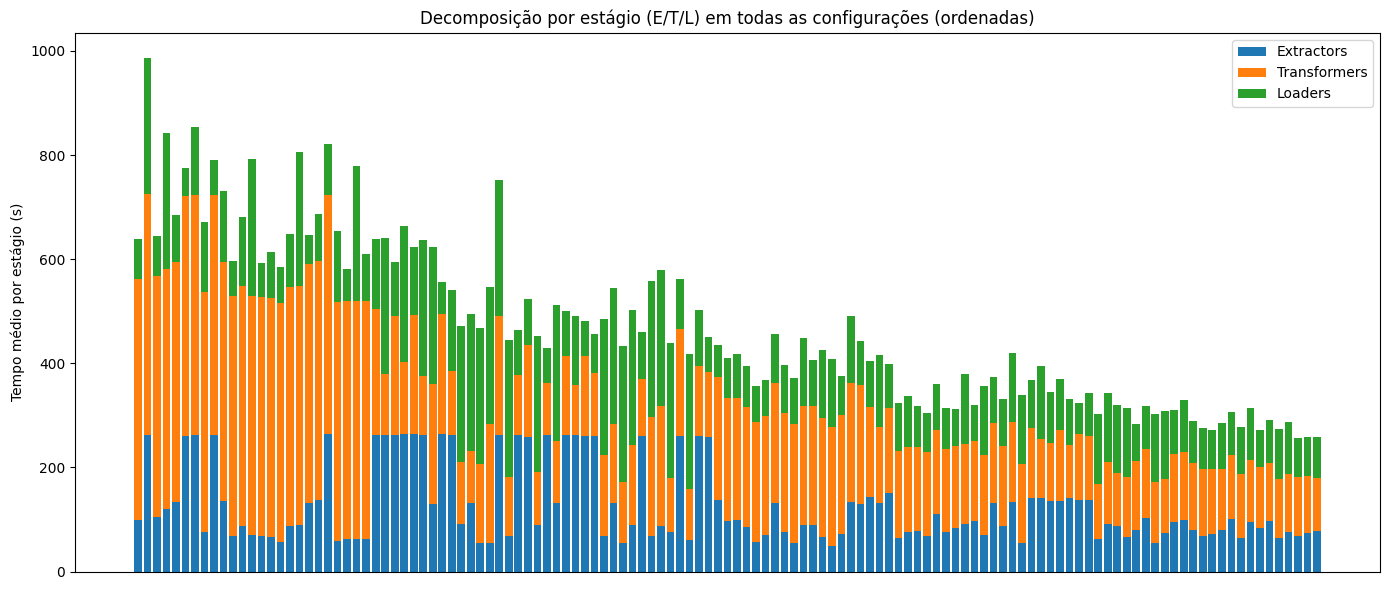

In [14]:
x = np.arange(len(agg_result))
width = 0.8

e = agg_result["mean_extractors"].values
t = agg_result["mean_transformers"].values
l = agg_result["mean_loaders"].values

plt.figure(figsize=(14, 6))
plt.bar(x, e, width, label="Extractors")
plt.bar(x, t, width, bottom=e, label="Transformers")
plt.bar(x, l, width, bottom=e+t, label="Loaders")

plt.xticks([])
plt.ylabel("Tempo médio por estágio (s)")
plt.title("Decomposição por estágio (E/T/L) em todas as configurações (ordenadas)")
plt.legend()
plt.tight_layout()
plt.show()


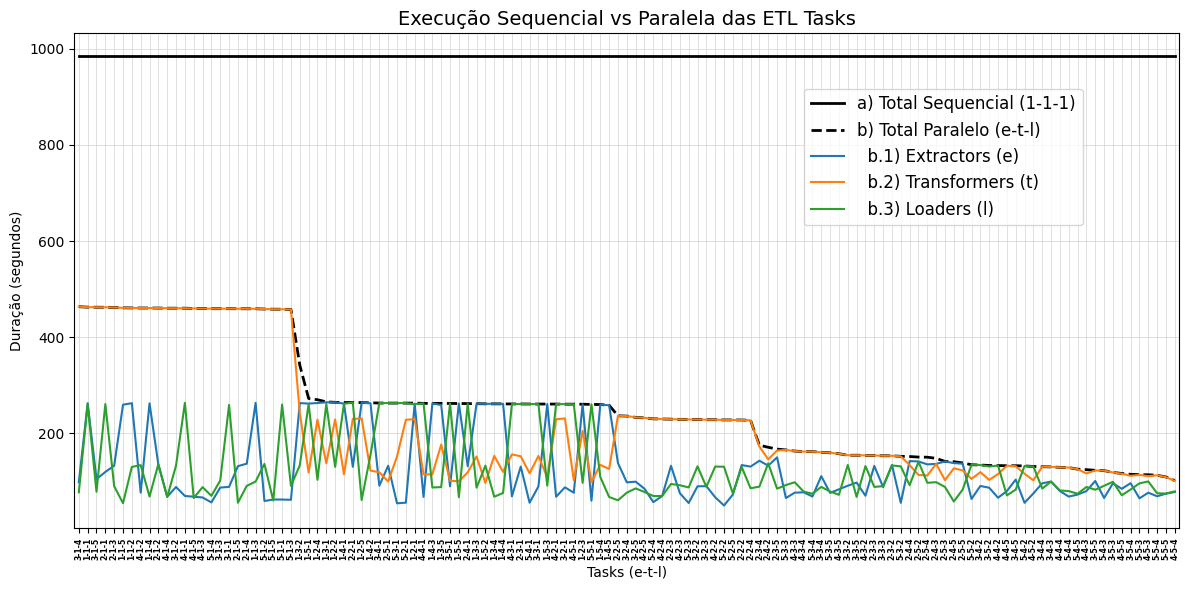

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(agg_result['tasks'], agg_result['sequential_time'], 
         label='a) Total Sequencial (1-1-1)', color='black', linewidth=2)
plt.plot(agg_result['tasks'], agg_result['mean_time'], 
         label='b) Total Paralelo (e-t-l)', 
         color='black', linestyle='--', linewidth=2)
plt.plot(agg_result['tasks'], agg_result['mean_extractors'], 
         label='  b.1) Extractors (e)')
plt.plot(agg_result['tasks'], agg_result['mean_transformers'], 
         label='  b.2) Transformers (t)')
plt.plot(agg_result['tasks'], agg_result['mean_loaders'], 
         label='  b.3) Loaders (l)')

plt.xlabel('Tasks (e-t-l)')
plt.ylabel('Duração (segundos)')
plt.title('Execução Sequencial vs Paralela das ETL Tasks', fontsize=14)
plt.xticks(rotation=90, fontsize=5.6, fontweight="bold")
plt.legend(fontsize=12, loc='center right', bbox_to_anchor=(0.92, 0.75))
plt.grid(color='lightgray', linewidth=0.5)

plt.xlim(-0.5, len(agg_result) - 0.5)

plt.tight_layout()
plt.show()


In [16]:
agg_result[agg_result['mean_rate'] > 1]\
    [['mean_time', 'tasks', 'mean_rate']]\
        .sort_values(by='mean_rate', ascending=False).reset_index(drop=True)

,mean_time,tasks,mean_rate
0,101.60,4-5-4,1.24
1,109.01,5-5-5,1.16
2,113.86,5-5-3,1.12
3,112.58,5-5-4,1.12
4,114.58,3-5-4,1.11
5,113.65,4-5-3,1.11
6,116.38,4-5-5,1.09
7,118.46,3-5-3,1.07
8,122.87,3-5-5,1.04
9,122.35,5-4-3,1.03


In [17]:
pd.set_option("display.float_format", "{:.3e}".format)

result["tasks"] = result["tasks"].astype("category") 

model_time = ols("total_pipeline_time ~ C(tasks)", data=result).fit()
anova_time = sm.stats.anova_lm(model_time, typ=2)
print("\nANOVA - Total Pipeline Time")
print(anova_time)

model_rate = ols("batches_rate ~ C(tasks)", data=result).fit()
anova_rate = sm.stats.anova_lm(model_rate, typ=2)
print("\nANOVA - Batches Rate")
print(anova_rate)

model_variance = ols("etl_variance ~ C(tasks)", data=result).fit()
anova_variance = sm.stats.anova_lm(model_variance, typ=2)
print("\nANOVA - ETL Variance")
print(anova_variance)


ANOVA - Total Pipeline Time
            sum_sq        df         F    PR(>F)
C(tasks) 1.723e+07 1.240e+02 1.861e+02 0.000e+00
Residual 8.397e+05 1.125e+03       NaN       NaN

ANOVA - Batches Rate
            sum_sq        df         F    PR(>F)
C(tasks) 8.978e+01 1.240e+02 1.869e+02 0.000e+00
Residual 4.359e+00 1.125e+03       NaN       NaN

ANOVA - ETL Variance
            sum_sq        df         F    PR(>F)
C(tasks) 3.042e+11 1.240e+02 4.800e+01 0.000e+00
Residual 5.749e+10 1.125e+03       NaN       NaN
